# Coursework 2: Deep Learning with Images
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Eric-Tuan Le, Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any ways. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated. However feel free to change the number of epochs 

Each exercise must be implemented from scratch. Unless differently specified, only `Numpy`, `PyTorch` and `matplotlib` are allowed. We encourage to test the correctness of results using libraries.

In case you are suspected of plagiarism you might be requested to present your work in an one-to-one session
(date to be decided) demonstrating what you have implemented.



**Questions:**

[Question 1](#question1): Image, audio; all the same (15 points)

[Question 2](#question2): Denoising (25 points)

[Question 3](#question3): Auto-encoder (30 points)

[Question 4](#question4): Variational auto-encoder (30 points)

## Datasets

All the datasets must be contained in the `Datasets` folder at the same level of hierarchy as the notebook.
In this courswork you are going to use MNIST, CelebA, audio data and noisy images. Each dataset is used in a specific exercise. The data paths are already present in the code, please **do not** change it.

The Dataset (zipped) can be downloaded from here: http://geometry.cs.ucl.ac.uk/mlvc/courseworks/Datasets.zip

In [ ]:
# Uncomment to download the zip file
#!wget http://geometry.cs.ucl.ac.uk/mlvc/courseworks/Datasets.zip
#!unzip Datasets.zip

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [2]:
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
from skimage.metrics import peak_signal_noise_ratio
import os
import torchvision
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF

In [3]:
# install prettytable and uncomment to use count_paramters function
#!pip install -U prettytable
from prettytable import PrettyTable 

In [ ]:
# install livelossplot and uncomment below to plot losses live (while training) <- highly suggested
!pip install livelossplot
from livelossplot import PlotLosses

Set random seed

In [5]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Set device

In [6]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Create folder in which save models

In [7]:
os.makedirs('models', exist_ok=True)

### Utility functions

In [8]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])

    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 20))
    
    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])
    
    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()


def count_parameters(model):
    # you can use this function to print number parameters per layer
    # install prettytable and uncomment import to use count_paramters function
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## 1. Image, audio; all the same (15 points)
<a name='question1'></a>

[a)](#question1a) Implement a filter to remove low temporal frequencies (`highpass_fft_filter_audio`) from the audio file `audio.npy`, provided under `Datasets/Filtering/`. Plot the input and output of your filter as line graphs. (**2 points**) Implement a version using FFT (`highpass_fft_filter_audio`) and a version using moving average (`highpass_normal_filter_audio`) (**2 points**), discuss which version, when and why is better (**1 point**).

[b)](#question1b) Implement a filter to find vertical edges in an image. We provide a sample file `image.png` under
`Datasets/Filtering/` for testing. Apply your filter to this image and display the input and output of your filter. (**8 points**) Implement the filter without for loops (**2 points**).


**Question 1.a**
<a name='question1a'></a>

Implement a filter to remove low temporal frequencies

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [9]:
def highpass_fft_filter_audio(audio):
    #solution
    audioFFT = np.fft.fft(audio)
    audioFFTShift = np.fft.fftshift(audioFFT)
    audioFFTMag = np.abs(audioFFTShift)

    #plot the frequency domain after applying fft and shift
    noOfSample = len(audio)
    freqs = np.arange(noOfSample) / noOfSample - 0.5
    figure, axis = plt.subplots(1, 1, figsize=(12, 3))
    axis.set_title('Frequency Components After Fourier Transform')
    axis.plot(freqs, audioFFTMag)
    axis.set_xlabel('Frequency')
    axis.set_ylabel('Amplitude')
    plt.show()
    
    
    threshold = 0.1
    filterFreqs = np.where( (freqs > -threshold) & (freqs < threshold))
    filtered_audio_FFT = np.array(audioFFTShift)
    filtered_audio_FFT[filterFreqs] = 0 + 0j

    #plot the frequency domain after applying filtering
    figure, axis = plt.subplots(1, 1, figsize=(12, 3))
    axis.set_title('Frequency Components After Filtering')
    axis.plot(freqs, abs(filtered_audio_FFT ))
    axis.set_xlabel('Frequency')
    axis.set_ylabel('Amplitude')
    plt.show()

    filtered_audio_ifft_shift = np.fft.ifftshift(filtered_audio_FFT)
    filtered_audio_ifft = np.fft.ifft(filtered_audio_ifft_shift)
    filtered_audio = filtered_audio_ifft.real

    #end_solution
    return filtered_audio

In [10]:
def highpass_normal_filter_audio(audio):
    filtered_audio = None
    #solution
    '''
    For moving average filter with window size 3,
    we first need to create a moving window array (e.g.[1/3, 1/3, 1/3])
    and then we convolve with the signal.
    For example, an array X = [1,2,3,4,5]
    when we convolve X with moving window w = [1/3, 1/3, 1/3] (i.e. result = np.convolve(X,w, "same"))
    what it does is as following:

          [1/3, 1/3, 1/3]
                [  1,   2,   3,   4,   5]
      result[0] = 0 * 1/3 + 1 * 1/3 + 2 * 1/3 = 1

                [1/3, 1/3, 1/3]
                [  1,   2,   3,   4,   5]
      result[1] = 1 * 1/3 + 2 * 1/3 + 3 * 1/3 = 2

                    [1/3, 1/3, 1/3]
                [  1,   2,   3,   4,   5]
      result[2] = 2 * 1/3 + 3 * 1/3 + 4 * 1/3 = 3

                          [1/3, 1/3, 1/3]
                [  1,   2,   3,   4,   5]
      result[3] = 3 * 1/3 + 4 * 1/3 + 5 * 1/3 = 4

                               [1/3, 1/3, 1/3]
                [  1,   2,   3,   4,   5]
      result[4] = 4 * 1/3 + 5 * 1/3 + 0 * 1/3 = 3

    From the above, we can see result[1], result[2] and result[3] is actually
    taking average of 3 neighbouring samples, such that:
    result[1] = (X[0] + X[1] + X[2]) / 3
    result[2] = (X[1] + X[2] + X[3]) / 3
    result[3] = (X[2] + X[3] + X[4]) / 3

    Therefore we can get the moving average for each element by convolving 
    the two array, so that for moving window size 3, 
    result[i] = (X[i-1] + X[i] + X[i+1]) / 3,
    '''
    windowSize = 15
    # create a moving window
    movingWindow = np.ones(windowSize) * (1 / windowSize)
    filtered_audio = np.convolve(audio, movingWindow, "same")
    filtered_audio = audio - filtered_audio
    #end_solution
    return filtered_audio

In [11]:
audio_rate = 44e3   # The audio sample is assumed to have been acquired at 44Khz sampling rate

Load  audio from file

In [12]:
# load input_audio from input_audio_filename
input_audio_filename = "./Datasets/Filtering/audio.npy"
input_audio = np.load(input_audio_filename)
print(f"Audio array shape: {input_audio.shape}")

# The audio sample played at 44khz sampling rate. Basically a 1 second noise sample. 
IPython.display.Audio(input_audio, rate=audio_rate)

Audio array shape: (1000,)


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Run filtering with input data 

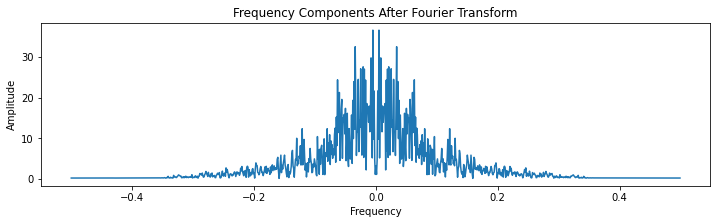

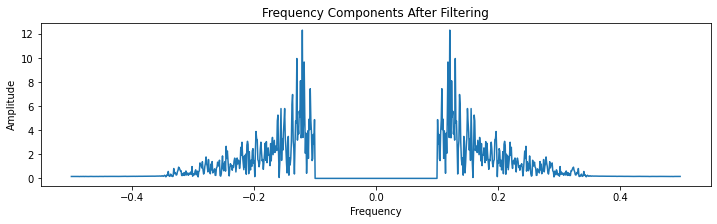

In [14]:
input_audio = np.load(input_audio_filename)
filtered_audio = highpass_fft_filter_audio(input_audio)

In [15]:
print("Original audio")
IPython.display.Audio(input_audio, rate=audio_rate)

Original audio


In [16]:
print("Filtered audio")
IPython.display.Audio(filtered_audio, rate=audio_rate)

Filtered audio


Plot the original audio and the filtered version

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

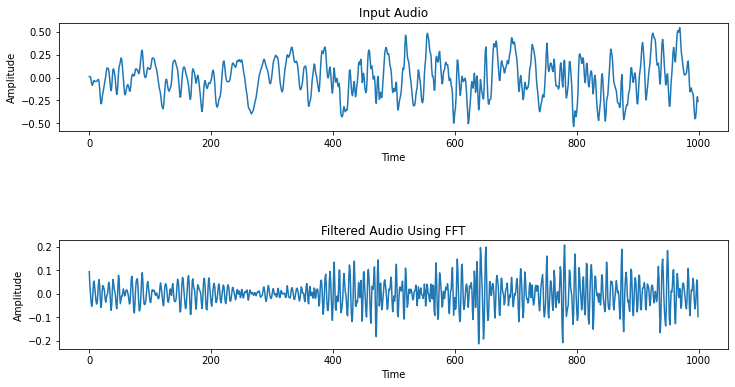

In [17]:
# plot input_audio and filtered_audio

#solution
samplingInterval = 1 / audio_rate
time = np.arange(0, len(input_audio), dtype=np.float64)
#time *= samplingInterval

# Create subplot
figure, axis = plt.subplots(2, 1, figsize=(12, 6))
plt.subplots_adjust(hspace=1)
# Time domain representation for sine wave 1
axis[0].set_title('Input Audio')
axis[0].plot(time, input_audio)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
# Time domain representation for sine wave 2
axis[1].set_title('Filtered Audio Using FFT')
axis[1].plot(time, filtered_audio)
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
plt.show()
#end_solution


In [18]:
input_audio = np.load(input_audio_filename)
filtered_audio = highpass_normal_filter_audio(input_audio)

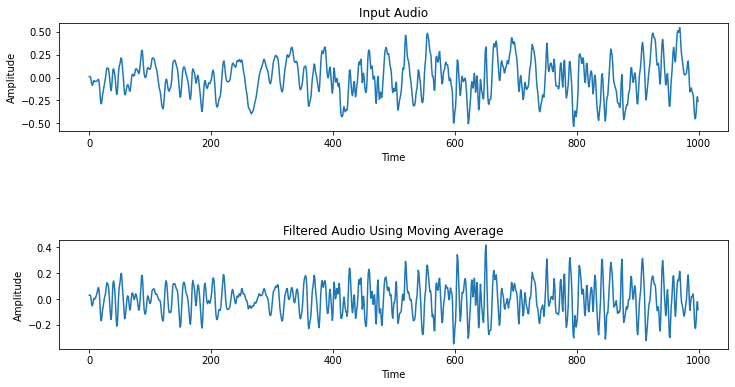

In [19]:
# plot input_audio and filtered_audio

#solution
samplingInterval = 1 / audio_rate
time = np.arange(0, len(input_audio), dtype=np.float64)
#time *= samplingInterval


figure, axis = plt.subplots(2, 1, figsize=(12, 6))
plt.subplots_adjust(hspace=1)
# Time domain representation for input audio
axis[0].set_title('Input Audio')
axis[0].plot(time, input_audio)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
# Time domain representation for filtered audio
axis[1].set_title('Filtered Audio Using Moving Average')
axis[1].plot(time, filtered_audio)
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
plt.show()
#end_solution


**Discuss which version of filter, when and why is better?** 

The moving average filter is good for reducing random noise while retaining a sharp step response. Due to its simplicity, it can be apply to different real-time appication and suitable for time domain encoded signals.

However, since moving average filter just taking average inside a moving window in time-domain, it cannot well separate one band of frequencies from another. Therefore, for frequency domain encoded signals such as our audio signal here, a FFT highpass filter is more suitable since it uses Fourier Transform to transform the signal from time-domain to frequency-domain. We can then well separate different band of frequencies and filter out the one we want, and finally we can reconstruct the signal back to time-domain after filtering.


**Question 1.b**
<a name='question1b'></a>

Implement a filter to find vertical edges in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [20]:
def detect_vertical_edges(image):
    #solution
    def convolve2DArray(img, filter):
        ''' Instead of using for loop to convolve two 2D array, we can use 
            einsum to compute the convolution without for loops. 

            For a matrix M = [[ 0  1  2  3  4]
                                [10 11 12 13 14]
                                [20 21 22 23 24]
                                [30 31 32 33 34]],

            and a filter f = [[0 1 2]
                                [3 4 5]
                                [6 7 8]]
            
            We know that the result will be a 3 by 2 matrix after convolution.
            Therefore, we first create a (3 by 3 by 3 by 2) sub matrices,
            subMat = [[[ 0  1  2]  [[ 1  2  3]  [[ 2  3  4]
                        [10 11 12]], [11 12 13]], [12 13 14]],

                        [[10 11 12]  [[11 12 13]  [[12 13 14]
                        [20 21 22]], [21 22 23]], [22 23 24]],

                        [[20 21 22]  [[21 22 23]  [[22 23 24]
                        [30 31 32]], [31 32 33]], [32 33 34]]]

            Then we multiply the each small matrix from subMat with the 
            corresponding element from the filter, such that:
                
            newM = f[i,j] * subMat[i,j] =
                    [ 0 * [[ 0  1  2]  1 * [[ 1  2  3]  2 * [[ 2  3  4]
                            [10 11 12]],     [11 12 13]],     [12 13 14]],

                        3 * [[10 11 12]  4 * [[11 12 13]  5 * [[12 13 14]
                            [20 21 22]],     [21 22 23]],     [22 23 24]],

                        6 * [[20 21 22]  7 * [[21 22 23]  8 * [[22 23 24]
                            [30 31 32]],     [31 32 33]],     [32 33 34]]]
            
            Finally, we can sum up each corresponding element of each 
            small matrix from newM, such that:
                convolved = newM[0,0] + newM[0,1] + newM[0,2]
                            +newM[1,0] + newM[1,1] + newM[1,2]
                            +newM[2,0] + newM[2,1] + newM[2,2]

            And we can get a 3 by 2 convolved matrix.
            
        '''
        # shape of each small matrix in the sub matrices (m,n)
        smallMatrixShape = tuple(np.subtract(img.shape, filter.shape) + 1)
        # shape of the sub matrices (filter.shape[0], filter.shape[1], m, n) (i.e. 4-D array)
        subMatShape = filter.shape + smallMatrixShape
        # create the sub matrices with shape (filter.shape[0], filter.shape[1], m, n)
        strideObj = np.lib.stride_tricks.as_strided
        stride = img.strides * 2
        subMat = strideObj(img, shape=subMatShape, strides=stride)

        # Convolution using einsum.
        # Repeating letter in different input means those values will be multiplied
        # and those products will be the output.
        # Omitting letters means those axis will be summed
        convolved2DArr = np.einsum('ij,ijkl->kl', filter, subMat)

        return convolved2DArr

    # convert image from RGB to grayscale
    grayImage = cv2.cvtColor(src=image, code=cv2.COLOR_RGB2GRAY)
    # add padding around the image
    paddedGrayImage = np.pad(grayImage, (1, 1), 'edge')
    # create a vertical edge filter
    filter = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
    # convolve the image with the filter to detect vertical edges
    filtered_image = convolve2DArray(paddedGrayImage, filter)
    #end_solution

    return filtered_image

In [21]:
input_image_filename = "./Datasets/Filtering/image.png"

Run filter over the input image

In [22]:
input_image = np.asarray(PIL.Image.open(input_image_filename).convert('RGB'))
filtered_image = detect_vertical_edges(input_image)

Display the original image and its filtered version side by side

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

(512, 512, 3)
(512, 512)


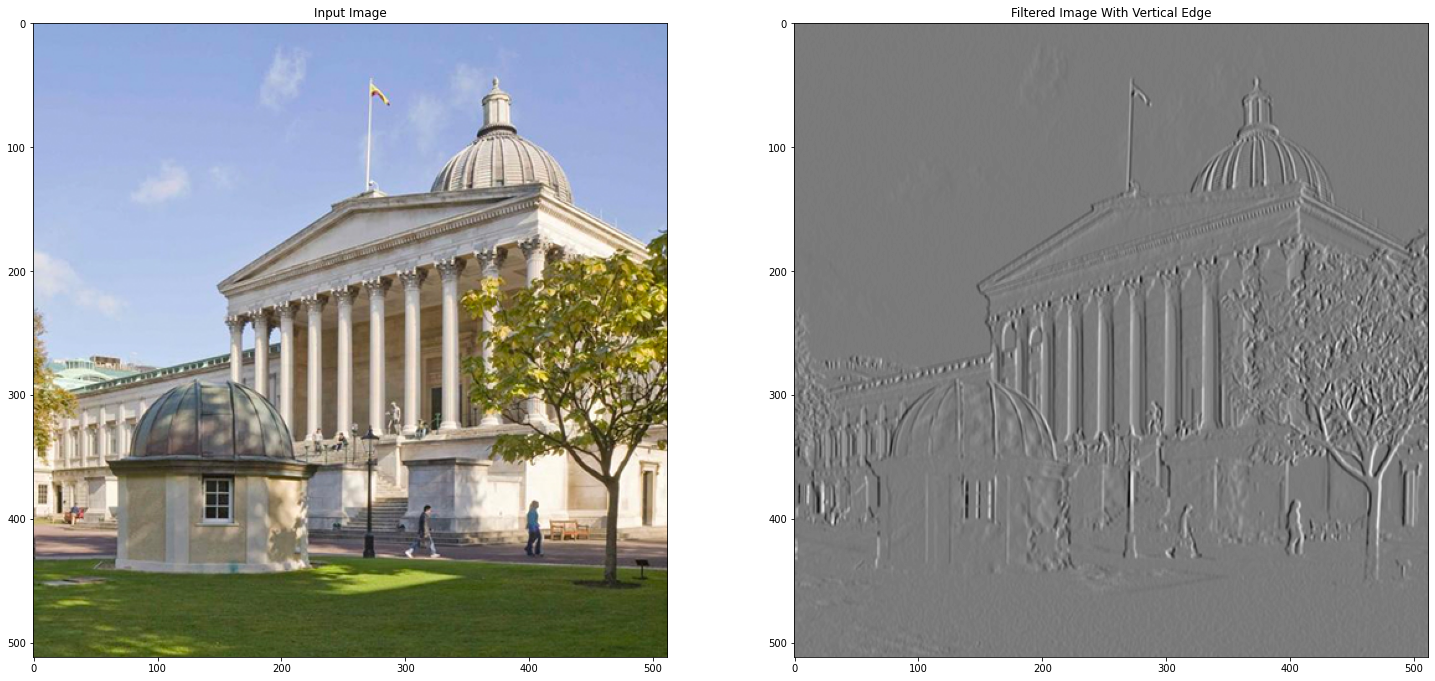

In [23]:
# display input_image and filtered_image here

#solution
print(input_image.shape)
print(filtered_image.shape)

figure, axis = plt.subplots(1, 2, figsize=(25, 25))
# show input image
axis[0].set_title('Input Image')
axis[0].imshow(input_image)
# show filtered image
axis[1].set_title('Filtered Image With Vertical Edge')
axis[1].imshow(filtered_image, cmap=plt.get_cmap('gray'))
plt.show()

#end_solution



## 2. Denoising (25 points)
<a name='question2'></a>

[a)](#question2a) Implement `denoiseGauss(image)` to denoise the image noisy `image.png` under `Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#question2b) Implement a pyramidal encoder-decoder to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `Datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The encoder and decoder must have at least 3 layers each. Please use ReLU non-linearities after each layer (**15 points**).
Please train for no more than 400 epochs.

[c)](#question2c) Write a markdown block in your notebook, comparing the Gaussian and encoder-decoder denoising
methods. Include example output images from each method and discuss which method performs better and where. You should write no more than half a page. (**5 points**)

**Question 2.a**
<a name='question2a'></a>

Implement the function to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [24]:
def gkern(l=5, sig=1.):
    
    #solution
    if l < 1 or l == None:
      l = 1
    
    if l%2 == 0:
      l += 1

    shift = (l-1.0) / 2.0
    x,y = np.ogrid[0:l, 0:l]
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    x -= shift
    y -= shift
    # Gaussian Filter is defined as: G(x,y) = (1/(2πσ^2)) * e^(-(x^2 + y^2) / (2σ^2))
    # Here we do not divided the exponential term by (2πσ^2),
    # but instead divided by the sum of each element of the matrix,
    # such that the sum of each element of the out_kernel is equal to 1.
    out_kernel = np.exp( (-(x**2 + y**2)) / (2 * (sig**2)))
    out_kernel = out_kernel / np.sum(out_kernel)
    #end_solution

    
    return out_kernel

def denoise_gauss(image):
    
    #solution
    def convolve2DArray(img, filter):
        smallMatrixShape = tuple(np.subtract(img.shape, filter.shape) + 1)
        subMatShape = filter.shape + smallMatrixShape
        strideObj = np.lib.stride_tricks.as_strided
        stride = img.strides * 2
        subMat = strideObj(img, shape=subMatShape, strides=stride)
        convolved2DArr = np.einsum('ij,ijkl->kl', filter, subMat)
        return convolved2DArr

    # create a 5 by 5 gaussian filter with sigma = 5
    gaussianKernel = gkern(5, 1.0)
    height, width, dim = image.shape
    noisyImg = np.array(image)
    denoised_image = np.zeros((height, width, dim))
    for i in range(dim):
        # add padding
        noisyImgPadded = np.pad(noisyImg[:,:,i], (2, 2), 'edge')
        # convolve each RGB channel with the gaussian filter
        denoised_image[:,:,i] = convolve2DArray(noisyImgPadded, gaussianKernel)
    
    #end_solution

    
    return denoised_image

Load input image from file

In [25]:
noisy_image_filename = "./Datasets/Filtering/noisy_image.png"

Filter the input image

In [26]:
noisy_image = np.asarray(PIL.Image.open(noisy_image_filename).convert('RGB'))
denoised_image = denoise_gauss(noisy_image)

Display the input image and its filtered version side by side

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

(512, 512, 3)
(512, 512, 3)


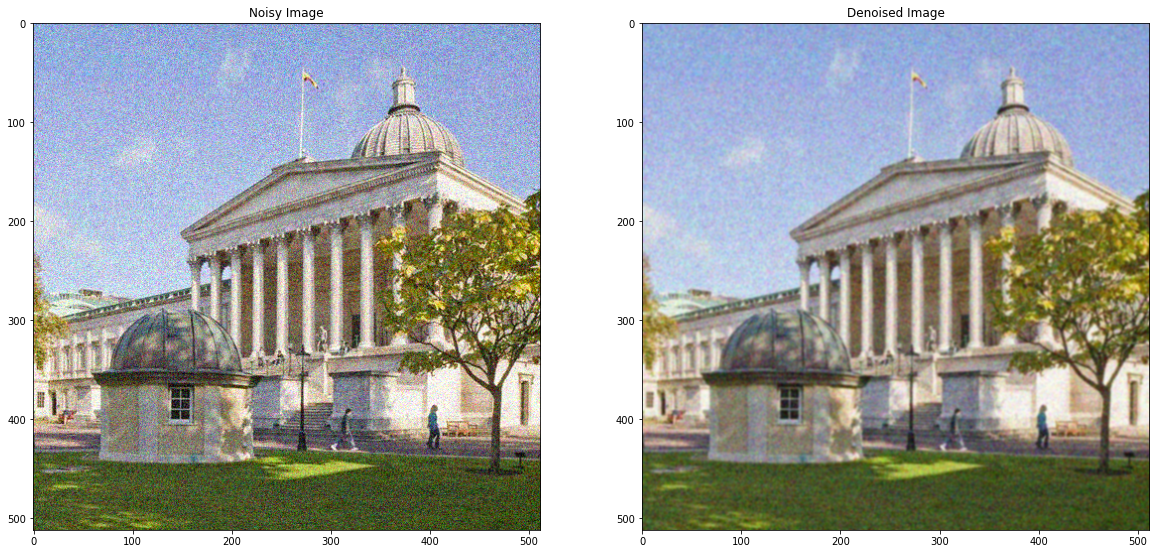

In [27]:
# display input_image and denoised_image here
#solution
print(noisy_image.shape)
print(denoised_image.shape)

figure, axis = plt.subplots(1, 2, figsize=(20, 20))
# show input image
axis[0].set_title('Noisy Image')
axis[0].imshow(noisy_image)
# show filtered image
axis[1].set_title('Denoised Image')
axis[1].imshow(denoised_image.astype(np.uint8))
plt.show()
#end_solution


**Question 2.b**
<a name='question2b'></a>

Implement dataset class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
class DenoisingDB(Dataset):
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()
        
        #solution
        
        # create a list that store the tuple of (input_image, target_image)
        self.data = []
        fnames = os.listdir(input_imgs_path)
        # for each image pair, store them to the list
        for idx, fname in enumerate(fnames):
            inputImg = PIL.Image.open(os.path.join(input_imgs_path, fname)).convert('RGB')
            cleanedImg = PIL.Image.open(os.path.join(cleaned_imgs_path, fname)).convert('RGB')
            # convert PIL image to numpy array with size (H,W,C) with range 0 to 255
            inputImgArr = np.asarray(inputImg)
            cleanedImgArr = np.asarray(cleanedImg)
            # convert (H,W,C) numpy array to (C,H,W) tensor with with range 0 to 1
            inputImgTensor = transforms.ToTensor()(inputImgArr)
            cleanedImgTensor = transforms.ToTensor()(cleanedImgArr)
            # store the tensor to the list
            self.data.append((inputImgTensor, cleanedImgTensor))

        #end_solution


    def __len__(self):
        
        #solution
        length = len(self.data)
        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution
        input_image, target_image = self.data[idx]
        #end_solution

        
        return (input_image, target_image)

Implement the Encoder network: 5 levels and double the number of internal activations when reducing the spatial resolution. Please use ReLU non-linearities.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [29]:
class Encoder(Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        #solution
        channel_size = 3
        self.encoder = nn.Sequential(
            nn.Conv2d(channel_size, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        #end_solution


    def forward(self,high_res_image):
        
        #solution
        #low_res_image = high_res_image
        low_res_image = self.encoder(high_res_image)
        #end_solution

        
        return low_res_image

Implement the Decoder network: 5 levels and half the number of internal activations when increasing the spatial resolution. Please use ReLU non-linearities.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [30]:
class Decoder(Module):

    def __init__(self):
        super(Decoder, self).__init__()
        
        #solution
        
        channel_size = 3
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, channel_size, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
        #end_solution


    def forward(self, low_res_image):
        
        #solution
        #denoised_image = low_res_image
        denoised_image = self.decoder(low_res_image)
        #end_solution

        
        return denoised_image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [31]:
def loss_function(input,target):
    
    #solution
    loss = nn.MSELoss()(input, target)
    #end_solution

    
    return loss

Paths input data

In [32]:
input_imgs_path = "./Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "./Datasets/Denoising/target_clean_images"

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

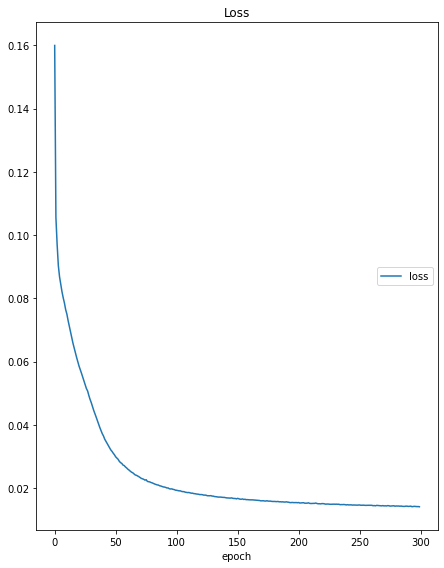

Loss
	loss             	 (min:    0.014, max:    0.160, cur:    0.014)
loss in epoch 300  : 0.014076494492150636


In [33]:
docs_dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)
encoder = Encoder().to(device)
decoder = Decoder().to(device)

#solution
train_loader = DataLoader(docs_dataset, batch_size=1, shuffle=True)
optimizer = optim.Adam([{'params': encoder.parameters()}, {'params': decoder.parameters()}], lr=0.0005)
encoder.train()
decoder.train()

liveloss = PlotLosses()
noOfEpochs = 300
for epoch in range(noOfEpochs):
    trainLoss = 0
    for inputImg, cleanedImg in train_loader:
        # crop a 256 by 256 from input image and cleaned image
        outH, outW = 256, 256
        n, c, h, w = inputImg.size()
        i, j = int(round(w/2.0) - (outW/2.0)), int(round(h/2.0) - (outH/2.0))
        inputImgCropped = TF.crop(inputImg, i, j, outH, outW)
        cleanedImgCropped = TF.crop(cleanedImg, i, j, outH, outW)
        inputImgCropped = inputImgCropped.cuda()
        cleanedImgCropped = cleanedImgCropped.cuda()
        #print("cleanedImgCropped size:",cleanedImgCropped.size())
        #print("inputImgCropped size:",inputImgCropped.size())
        
        #inputImg = inputImg.cuda()
        #print("inputImg size:", inputImg.size())
        code = encoder(inputImgCropped)
        #code = encoder(inputImg)
        #print("code size:", code.size())
        #print("min:", torch.min(code))
        #print("max:", torch.max(code))
        pred = decoder(code)
        #print("pred size:", pred.size())
        loss = loss_function(pred, cleanedImgCropped)
        #print("loss: ", loss)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainLoss /= len(train_loader)
    liveloss.update({'loss': trainLoss})
    liveloss.send()
    print("loss in epoch", format(epoch + 1, '03d'), " :", trainLoss)
#end_solution



Save the model (needed for marking)

In [34]:
torch.save({'encoder':encoder, 'decoder':decoder}, 'models/ex2b.pth')

Load trained model

In [35]:
state_dict = torch.load('models/ex2b.pth')
encoder = state_dict['encoder'].to(device)
decoder = state_dict['decoder'].to(device)

Plot 5 input images and their relative denoised images side by side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

denoisedImg size:  torch.Size([3, 420, 540])
denoisedImg size:  torch.Size([3, 258, 540])
denoisedImg size:  torch.Size([3, 420, 540])
denoisedImg size:  torch.Size([3, 258, 540])
denoisedImg size:  torch.Size([3, 258, 540])


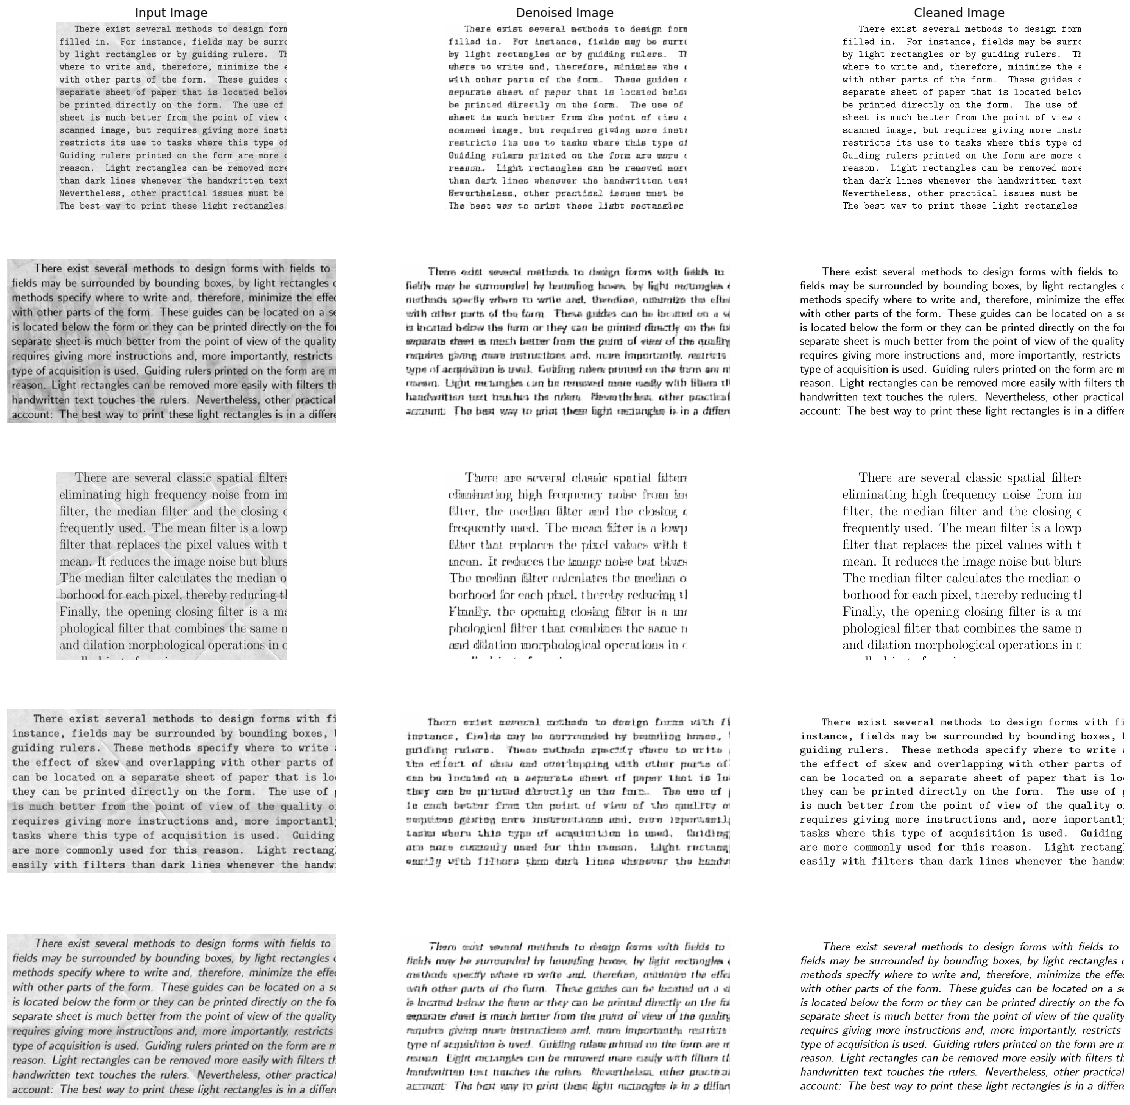

In [36]:
#solution
indices = np.random.choice(range(len(docs_dataset)), 5, replace=False)
randomImgsTuple = [docs_dataset[idx] for idx in indices]

noisyImgsList = []
cleanedImgsList = []
reconstructedImgsList = []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for noisyImg, cleanedImg in randomImgsTuple:
        c, h, w = noisyImg.size()
        if h == 258:
            noisyImg = TF.resize(noisyImg, (256, 512))
        elif h == 420:
            noisyImg = TF.resize(noisyImg, (416, 512))
        encodedImg = encoder(noisyImg.unsqueeze(0).cuda())
        denoisedImg = decoder(encodedImg).squeeze(0)
        c, h, w = denoisedImg.size()
        if h == 256:
            denoisedImg = TF.resize(denoisedImg, (258, 540))
        elif h == 416:
            denoisedImg = TF.resize(denoisedImg, (420, 540))
        print("denoisedImg size: ", denoisedImg.size())
        denoisedImgArr = denoisedImg.permute(1,2,0).cpu().numpy()
        reconstructedImgsList.append(denoisedImgArr)
        noisyImgArr = noisyImg.permute(1,2,0).numpy()
        noisyImgsList.append(noisyImgArr)
        cleanedImgArr = cleanedImg.permute(1,2,0).numpy()
        cleanedImgsList.append(cleanedImgArr)

titles = ['Input Image', 'Denoised Image', 'Cleaned Image']
plot_images([noisyImgsList, reconstructedImgsList, cleanedImgsList], titles, None)

#end_solution


**Question 2.c**
<a name='question2c'></a>

Load trained model

In [37]:
state_dict = torch.load('models/ex2b.pth')
encoder = state_dict['encoder'].to(device)
decoder = state_dict['decoder'].to(device)

Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

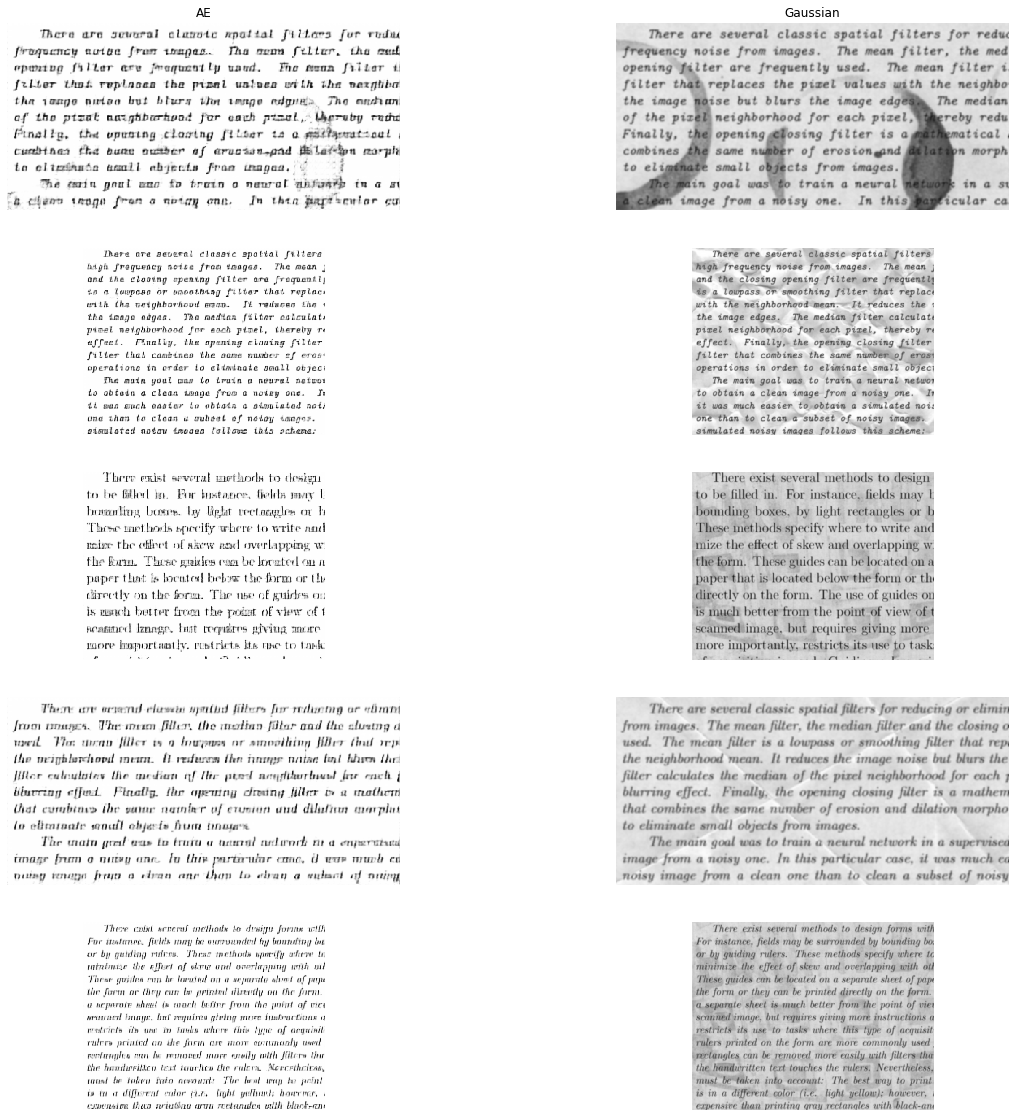

torch.Size([258, 540, 3])
torch.Size([258, 540, 3])
(258, 540, 3)
(258, 540, 3)


In [38]:
dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

images = [docs_dataset[i][0].to(device) for i in range(5)]
targets = [docs_dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

#solution
encoder.eval()
decoder.eval()
with torch.no_grad():
    for noisyImg in images:
        denoisedImgGauss = denoise_gauss(noisyImg.permute(1, 2, 0).cpu().numpy())
        #print("gauss:", denoisedImgGauss.shape)
        images_gauss.append(denoisedImgGauss)

        c, h, w = noisyImg.size()
        if h == 258:
            noisyImg = TF.resize(noisyImg, (264, 544))
        elif h == 420:
            noisyImg = TF.resize(noisyImg, (424, 544))
        code = encoder(noisyImg.unsqueeze(0))
        denoisedImgAE = decoder(code).squeeze(0)
        c, h, w = denoisedImgAE.size()
        if h == 264:
            denoisedImgAE = TF.resize(denoisedImgAE, (258, 540))
        elif h == 424:
            denoisedImgAE = TF.resize(denoisedImgAE, (420, 540))
        denoisedImgAE = denoisedImgAE.permute(1, 2, 0).cpu().numpy()
        #print("AE: ", denoisedImgAE.shape)
        images_ae.append(denoisedImgAE)
titles = ['AE', 'Gaussian']
plot_images([images_ae, images_gauss], titles, None)
images = [images[i].squeeze(0).permute(1,2,0) for i in range(5)]
targets = [targets[i].squeeze(0).permute(1,2,0) for i in range(5)]
print(images[0].shape)
print(targets[0].shape)
print(images_ae[0].shape)
print(images_gauss[0].shape)
#end_solution



Plot images and PSNR

In [39]:
imgs_plot = [ el.detach().squeeze().cpu().numpy() for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy() for el in targets]

(258, 540, 3)
(258, 540, 3)
(420, 540, 3)
(420, 540, 3)
(420, 540, 3)
(420, 540, 3)
(258, 540, 3)
(258, 540, 3)
(420, 540, 3)
(420, 540, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


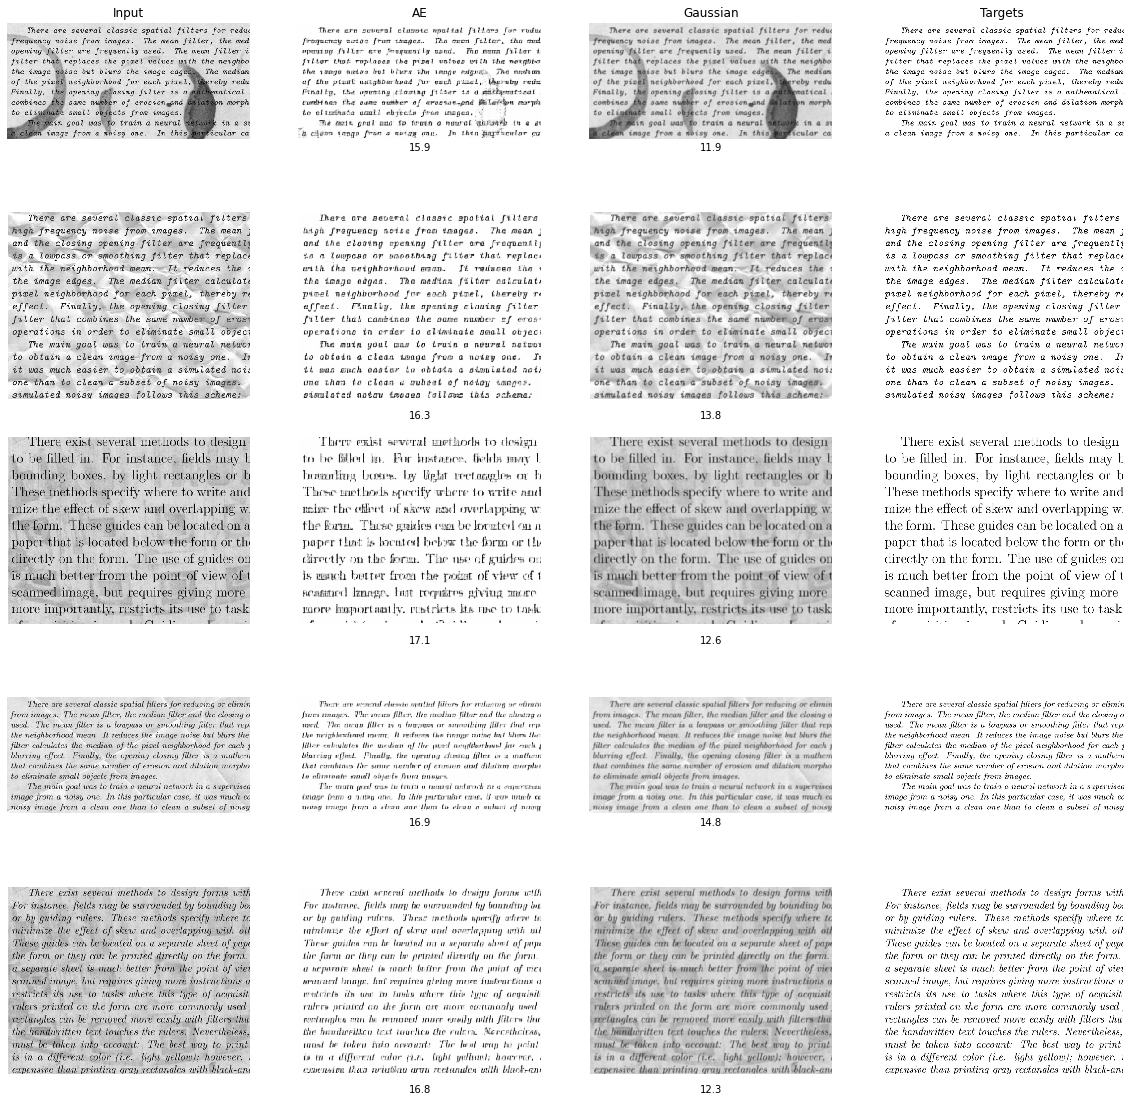

In [40]:
psnrs = [ 0.0 for el in targets ]
for i in range(len(tgts_plot)):
    print(tgts_plot[i].shape)
    print(images_ae[i].shape)
    psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']

img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images(img, titles, texts)
plt.show()

Comment on the results obtained from the plot above.

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_: 

Gaussian filter is a type of linear filter which is based on Gaussian function. It can be used for image denoising by convolve the gaussian filter with noisy image. The output image will be blurred and become more smooth since the color of each pixel of the output image is a weighted sum of the pixels within the kernel from the input image.

Autoencoder can also be used for image denoising. Instead of manipulating the matrix of the input image, the autoencoder will extract useful and important features of the image by increase the output channels of each layer using convolution and compressing the spatial dimension using pooling. The bottleneck layer will therefore have less dimensions than the input image and therefore dropout some useless information(ie. noise). It will then reconstruct a denoised image with the same size of the input image using the extracted information and reverse the encoding process. 

From the above figure, we can see that the Peak Signal-to-Noise Ratio is higher when using denoising autoencoder and lower when using gaussian filter. This is because the filters(i.e.kernels) of the autoencoer are learnable and we are optimising the parameters of the filters by comparing the loss between the denoised image and the cleaned target image during training. In this way, the computer will learn the filter rather than us human manually input the value of the gaussian filter. Therefore, using autoencdoer for image denoising is better than using gaussian filter. 

## 3. Auto-encoder (30 points)
<a name='question3'></a>

[a)](#question3a) Implement a convolutional auto-encoder (AE). The loss between in and output should be **L2**. You can make use of all the convolution, pooling, back-propagation and build-in functionality of `Pytorch` here. (**15 points**)
$$
||I −dec(enc(I))||^2_2
$$

[b)](#question3b) Test it on the MNIST (`Datasets/MNIST/`) dataset by encoding and decoding their first 5 samples. Compile a document showing, for each sample, the input and the AE reconstruction, side-by-side. (**5 points**)
Please train for no more than 100 epochs.

[c)](#question3c) Implement an auto-encoder (AE) and train it on CelebA. Choose the loss you deem more appropriate. Output 5 images from the AE you trained.  (**5 points**)

Please train it for no longer than 400 epochs.


[d)](#question3d) Discuss your design choices for Q3a and Q3c. Are the models different? Why? Discuss in no more than 15 sentences. If needed add plots and a demo. (**5 points**)



**Question 3.a**
<a name='question3a'></a>

Implement a convolutional auto-encoder

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [41]:
class AutoEncoder(Module):
    
    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        
        #solution
        
        if bottleneck_size > 128:
            self.bottleneck_size = 128

        ############### Encoder ###############
        # Convolution Layer
        self.encoder_conv = nn.Sequential(
            # 28 by 28  ==> 14 by 14
            nn.Conv2d(channel_size, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 14 by 14 ==> 7 by 7
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        
        # Flattening 
        self.encoder_flatten = nn.Flatten(start_dim=1)
        # Linear Layer
        self.encoder_linear = nn.Sequential(
            nn.Linear(7 * 7 * 16, 128),
            nn.ReLU(True),
            nn.Linear(128, bottleneck_size)
        )

        ############### Decoder ###############
        self.decoder_linear = nn.Sequential(
            nn.Linear(bottleneck_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 7 * 7 * 16),
            nn.ReLU(True)
        )

        self.decoder_unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, channel_size, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

        #end_solution

    
    def encoder(self,image):
        
        #solution
        #print("image size:", image.size())
        image = self.encoder_conv(image)
        #print("after conv:", image.size())
        image = self.encoder_flatten(image)
        #print("flattening:", image.size())
        code = self.encoder_linear(image)
        #print("linear: ", code.size())
        #end_solution

        
        return code
    
    def decoder(self,code):
        
        #solution
        #print("code size: ", code.size())
        code = self.decoder_linear(code)
        #print("decode linear size: ", code.size())
        code = self.decoder_unflatten(code)
        #print("unflatten size: ", code.size())
        code = self.decoder_conv(code)
        #print("decode conv size:", code.size())
        decoded_image = torch.sigmoid(code)
        #print("decoded_image size:", decoded_image.size())
        #end_solution

        
        return decoded_image
    
    def forward(self,image):
        
        #solution
        #print("Encode image ..............................")
        encoded_image = self.encoder(image)
        #print("Decode image ..............................")
        #decoded_image = encoded_image
        decoded_image = self.decoder(encoded_image)
        #end_solution

        
        return decoded_image

**Question 3.b**
<a name='question3b'></a>

Implement the dataset class to load MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [42]:
class MNIST(Dataset):
    
    def __init__(self, dataset_path):
        
        #solution
        self.data = []
        fnames = os.listdir(dataset_path)
        for fname in fnames:
            inputImg = PIL.Image.open(os.path.join(dataset_path, fname)).convert('RGB')
            # convert PIL image to numpy array with size (H,W,C) with range 0 to 255
            inputImgArr = np.asarray(inputImg)
            # convert (H,W,C) numpy array to (C,H,W) tensor with with range 0 to 1
            inputImgTensor = transforms.ToTensor()(inputImgArr)
            # store the tensor to the list
            self.data.append(inputImgTensor)
        #end_solution


    def __len__(self):
        
        #solution
        length = len(self.data)
        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution
        image = self.data[idx]
        #end_solution

        
        return image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [43]:
def reconstruction_loss(input,target):
    
    #solution
    recon_loss = nn.MSELoss()(input, target)
    #end_solution

    
    return recon_loss

Create dataloaders for training and validation

In [44]:
mnist_train_data_path = "./Datasets/MNIST/train/"
mnist_train_dataset = MNIST(mnist_train_data_path)

mnist_validation_data_path = "./Datasets/MNIST/validation/"
mnist_validation_dataset = MNIST(mnist_validation_data_path)

Train the AE on MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

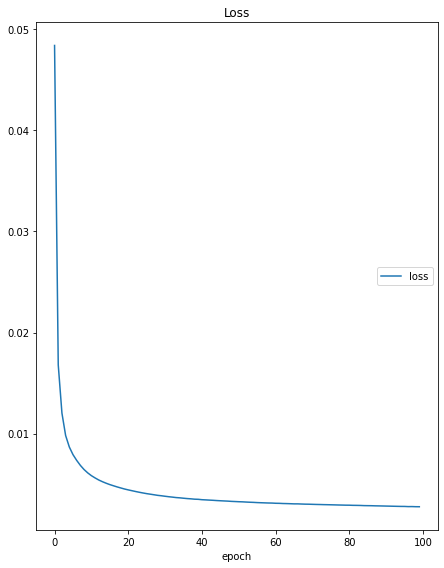

Loss
	loss             	 (min:    0.003, max:    0.048, cur:    0.003)
loss in epoch 100  : 0.0027750264873195973


In [45]:

mnist_autoencoder = None # your model (assign below)

#solution
mnist_autoencoder = AutoEncoder(bottleneck_size=64, channel_size=3).cuda()

train_loader = DataLoader(mnist_train_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(mnist_autoencoder.parameters(), lr=0.001)
mnist_autoencoder.train()

liveloss = PlotLosses()
noOfEpochs = 100
for epoch in range(noOfEpochs):
    trainLoss = 0
    for batch in train_loader:
        image = batch.cuda()
        pred = mnist_autoencoder(image)
        loss = reconstruction_loss(pred, image)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainLoss /= len(train_loader)
    liveloss.update({'loss': trainLoss})
    liveloss.send()
    print("loss in epoch", format(epoch + 1, '03d'), " :", trainLoss)

#end_solution


Save trained model (needed for marking)

In [46]:
torch.save(mnist_autoencoder, 'models/ex3.pth')

Load trained model

In [47]:
mnist_autoencoder = torch.load('models/ex3.pth')

Showing, for 5 samples in the validation set, the input and the AE reconstruction, side-by-side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

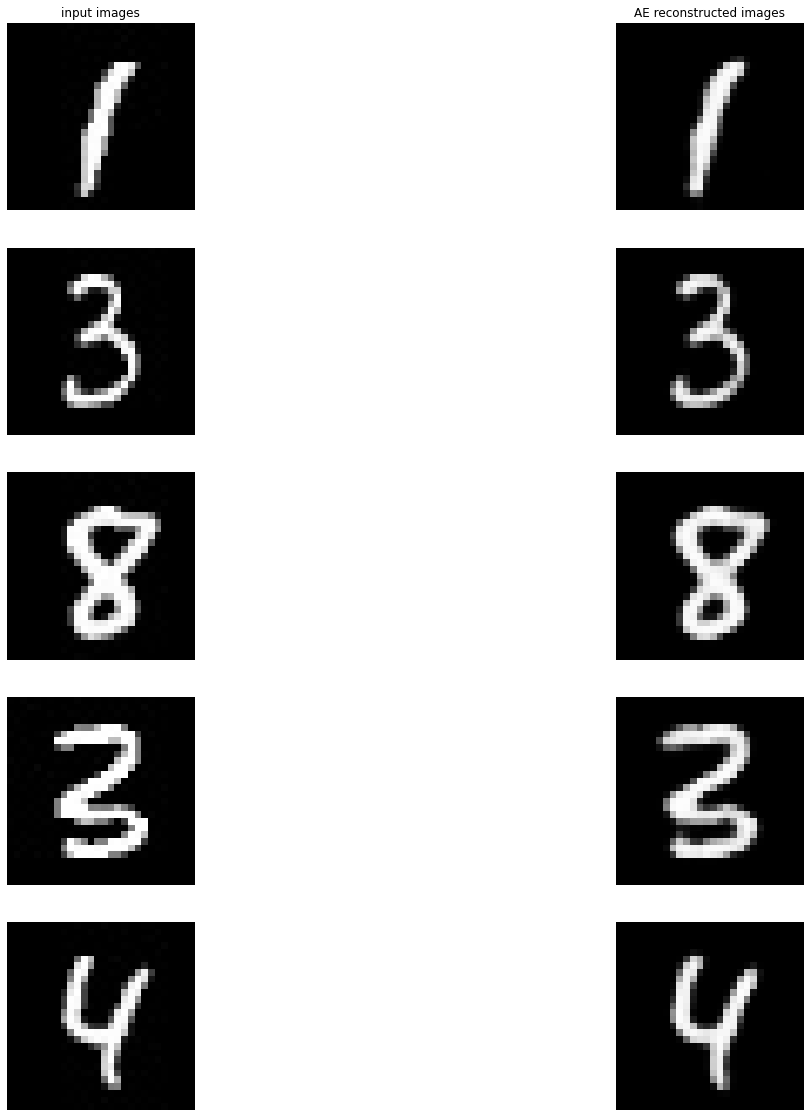

In [48]:
indices = np.random.choice(range(len(mnist_validation_dataset)), 5, replace=False)
mnist_random_images = [mnist_validation_dataset[idx] for idx in indices]


#solution
images = []
reconstructedImages = []
mnist_autoencoder.eval()
with torch.no_grad():
    for img in mnist_random_images:
        decodedImg = mnist_autoencoder(img.unsqueeze(0).cuda()).squeeze(0).permute(1, 2, 0).cpu().numpy()
        img = img.permute(1, 2, 0).numpy()
        images.append(img)
        reconstructedImages.append(decodedImg)

titles = ['input images', 'AE reconstructed images']
plot_images([images, reconstructedImages], titles, None)
#end_solution


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

**Question 3.c**
<a name='question3c'></a>

Write your AE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [71]:
class CebelAAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
        
        
        #solution
        ############### Encoder ###############

        # Convolution Layer
        self.encoder_conv = nn.Sequential(
            # 208 by 176  ==> 104 by 88
            nn.Conv2d(channel_size, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 104 by 88 ==> 52 by 44
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 52 by 44 ==> 26 by 22
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 26 by 22 ==> 13 by 11
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        
        # Flattening 
        self.encoder_flatten = nn.Flatten(start_dim=1)
        # Linear Layer
        self.encoder_linear = nn.Sequential(
            nn.Linear(64 * 13 * 11, bottleneck_size),
            nn.ReLU(True)
        )

        ############### Decoder ###############
        self.decoder_linear = nn.Sequential(
            nn.Linear(bottleneck_size, 64 * 13 * 11),
            nn.ReLU(True)
        )

        self.decoder_unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 13, 11))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, channel_size, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        #end_solution

    
    def encoder(self,image):
        
        #solution
        #print("image size:", image.size())
        image = self.encoder_conv(image)
        #print("after conv:", image.size())
        image = self.encoder_flatten(image)
        #print("flattening:", image.size())
        code = self.encoder_linear(image)
        #print("linear: ", code.size())
        #end_solution

        
        return code
        
    def decoder(self,code):
        #solution
        #print("code size: ", code.size())
        code = self.decoder_linear(code)
        #print("decode linear size: ", code.size())
        code = self.decoder_unflatten(code)
        #print("unflatten size: ", code.size())
        code = self.decoder_conv(code)
        #print("decode conv size:", code.size())
        decoded_image = torch.sigmoid(code)
        #print("decoded_image size:", decoded_image.size())
        #end_solution

        
        return decoded_image
    
    def forward(self, image):
        
        #solution
        #print("Encode image ..............................")
        encoded_image = self.encoder(image)
        #print("Decode image ..............................")
        #decoded_image = encoded_image
        decoded_image = self.decoder(encoded_image)
        #end_solution

        
        return decoded_image

    

Implete CelebA dataset class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [72]:
class CelebA(Dataset):
    
    def __init__(self, dataset_path):
        
        #solution
        self.data = []
        fnames = os.listdir(dataset_path)
        for fname in fnames:
            inputImg = PIL.Image.open(os.path.join(dataset_path, fname)).convert('RGB')
            # convert PIL image to numpy array with size (H,W,C) with range 0 to 255
            inputImgArr = np.asarray(inputImg)
            # convert (H,W,C) numpy array to (C,H,W) tensor with with range 0 to 1
            inputImgTensor = transforms.ToTensor()(np.array(inputImgArr))
            # resize the image to fit the AE
            #resizeInputImgTensor = TF.resize(inputImgTensor, (208, 176))
            outH, outW = 208, 176
            inputImgTensorCropped = TF.crop(inputImgTensor, 0, 0, outH, outW)
            # store the tensor to the list
            self.data.append(inputImgTensorCropped)
            #self.data.append(inputImgTensor)
        #end_solution


    def __len__(self):
        
        #solution
        length = len(self.data)
        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution
        image = self.data[idx]
        #end_solution

        
        return image


Create train and validation data loaders

In [73]:
celeba_train_data_path = "./Datasets/CelebA/train_subset/"
celeba_train_dataset = CelebA(celeba_train_data_path)

celeba_validation_data_path = "./Datasets/CelebA/val_subset/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)

In [74]:
print(celeba_train_dataset[0].size())

torch.Size([3, 208, 176])


Write your losses here

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [75]:
def reconstruction_loss(input,target):
    
    #solution
    #recon_loss = nn.MSELoss()(input, target)
    recon_loss = F.binary_cross_entropy(input, target, reduction='sum')
    #end_solution

    
    return recon_loss


Train AE on CelebA

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

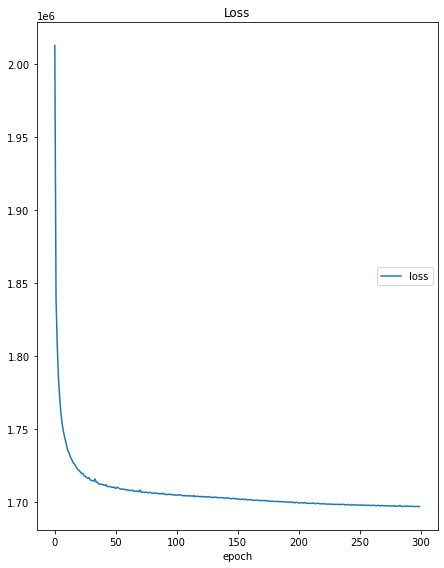

Loss
	loss             	 (min: 1696705.691, max: 2012561.891, cur: 1696883.278)
loss in epoch 300  : 1696883.2775559106


In [76]:

celeba_ae = None # create the AE and assign it to this

#solution
celeba_ae = CebelAAE(bottleneck_size=512, channel_size=3).to(device)

train_loader = DataLoader(celeba_train_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(celeba_ae.parameters(), lr=0.001)
celeba_ae.train()

liveloss = PlotLosses()
noOfEpochs = 300
for epoch in range(noOfEpochs):
    trainLoss = 0
    for batch in train_loader:
        image = batch.cuda()
        pred = celeba_ae(image)
        loss = reconstruction_loss(pred, image)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainLoss /= len(train_loader)
    liveloss.update({'loss': trainLoss})
    liveloss.send()
    print("loss in epoch", format(epoch + 1, '03d'), " :", trainLoss)

#end_solution




In [77]:
torch.save(celeba_ae, 'models/ex_3_ae.pth')

In [78]:
celeba_ae = torch.load("models/ex_3_ae.pth")

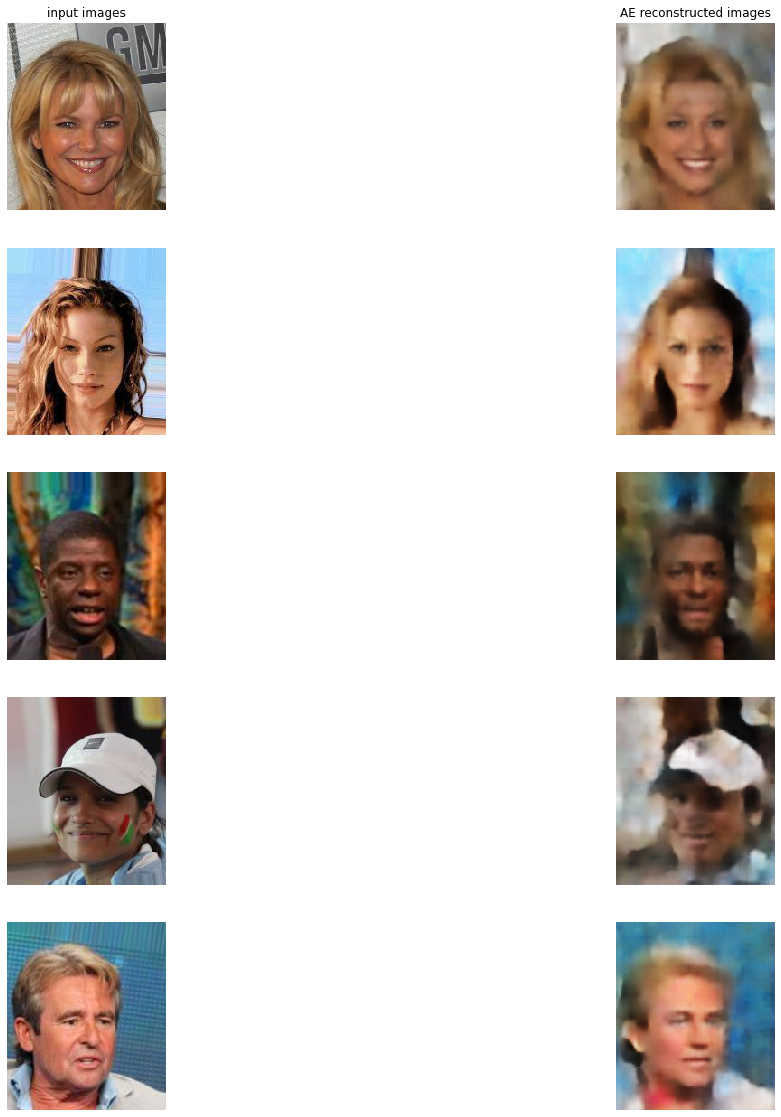

In [79]:
indices = np.random.choice(range(len(celeba_validation_dataset)), 5, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]


#solution
images = []
reconstructedImages = []
celeba_ae.eval()
with torch.no_grad():
    for img in celeba_random_images:
        decodedImg = celeba_ae(img.unsqueeze(0).cuda()).squeeze(0).permute(1, 2, 0).cpu().numpy()
        img = img.permute(1, 2, 0).numpy()
        images.append(img)
        reconstructedImages.append(decodedImg)

titles = ['input images', 'AE reconstructed images']
plot_images([images, reconstructedImages], titles, None)
#end_solution


**Question 3.d**
<a name='question3d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

The models for Q3a and Q3c are different. 

For Q3a, the input size of the mnist images are 28 by 28. The model first uses 2 convolution layers to reduce the spatial dimension by half after each layer. The output is then being flattened. Next, there are 2 linear layers to further compress down the dimension to the bottleneck size. The above process is then reversed in the decoder. 

For Q3c, the images of the celeba are first resized from 218 by 178 slightly down to 208 by 176 instead of a square image as Q3a. We are choosing 208 by 176 as the input size because these two numbers can be divided by 2 after using 4 convolution layers to reduce the spatial dimension down to 13 by 11. After 4 convolution layers, the output is then flattened as Q3a and the dimension is being compressed down to the bottleneck size using only one linear layer. The above process is then reversed in the decocer.

The design choice is based on the image resolution. First, we are using only 2 conv/deconv layers in Q3a, but using 4 conv/deconv layers in Q3c since the resolution of the celeba dataset is much larger then the mnist dataset, and therefore we choose to stack more layers for more down-sampling during encoding process. Moreover, there are 2 linear layers in the mnist dataset since those are black and white images and the digit can still be well recognised even using fewer dimensions. However, the celebA dataset are more complex are therefore we want to keep the bottleneck size larger in order to keep more information for having a better reconstruction result.

## 4. Variational auto-encoder (30 points)
<a name='question4'></a>

[a)](#question4a) Implement a Variational Auto-Encoder (VAE). (**10 points**)

[b)](#question4b) Train and test it on the CelebA dataset by **generating 5 samples**. (**10 points**)

Please train it for no longer than 400 epochs.


[c)](#question4c) Compare samples from the VAE to the samples of the AE (Q3c), by **generating 10 samples** and explain in one sentence what is the difference. (**5 points**)

[d)](#question4d) Explain the main differences between Adam and SGD (**1 points**). Discuss which are the terms used by Adam and what role they play (**1 points**). Prepare a demo to show the difference between training a network with ADAM vs SGD. Show the loss curves, discuss what are the differences and why (**3 points**). (total 5)


**Question 4.a**
<a name='question4a'></a>

Create the VAE class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [80]:
class VAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
        
        
        #solution
        ############### Encoder ###############
        self.encoder_conv = nn.Sequential(
            # 208 by 176  ==> 104 by 88
            nn.Conv2d(channel_size, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 104 by 88 ==> 52 by 44
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 52 by 44 ==> 26 by 22
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # 26 by 22 ==> 13 by 11
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )

        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.fc_mu = nn.Linear(64 * 13 * 11, bottleneck_size)
        self.fc_std = nn.Linear(64 * 13 * 11, bottleneck_size)
        
        ############### Decoder ###############
        self.decoder_linear = nn.Sequential(
            nn.Linear(bottleneck_size, 64 * 13 * 11),
            nn.ReLU(True),
            #nn.LeakyReLU(0.1)
        )

        self.decoder_unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 13, 11))


        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, channel_size, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        #end_solution

    
    def encoder(self,image):
        
        #solution
        encoded_image = self.encoder_conv(image)
        encoded_image = self.encoder_flatten(encoded_image)
        mu = self.fc_mu(encoded_image)
        std = self.fc_std(encoded_image)
        #end_solution

        
        return mu, std
    
    def reparametrization_trick(self,mu,std):
        
        #solution
        # since std cannot be negative, we take the exponent so that its minimum is 0 
        std = torch.exp(0.5 * std)
        # sample from standard normal distribution N(0,1)
        epsilon = torch.randn_like(std)
        # now the mean is mu and the standatd deviation is std
        z = mu + epsilon * std
        #end_solution

        
        return z
    
    def decoder(self,code):
        #solution
        decoded_image = self.decoder_linear(code)
        decoded_image = self.decoder_unflatten(decoded_image)
        decoded_image = self.decoder_conv(decoded_image)
        #end_solution

        
        return decoded_image
    
    def forward(self, image):
        
        #solution
        mu, std = self.encoder(image)
        z = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(z)
        #print("decoded image size:", decoded_image.size())
        #end_solution

        
        return decoded_image, mu, std

**Question 4.b**
<a name='question4b'></a>

Implement your losses here

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [81]:
def reconstruction_loss(input,target):
    
    #solution
    recon_loss = F.binary_cross_entropy(input, target, reduction='sum')
    #end_solution

    
    return recon_loss

def kl_divergence_loss(mu,std):
    
    #solution
    kl_loss = torch.mean(- 0.5 * torch.sum(1 + std - mu.pow(2) - std.exp(), dim = 1), dim = 0)
    #print(kl_loss)
    #end_solution

    
    return kl_loss

Train your VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

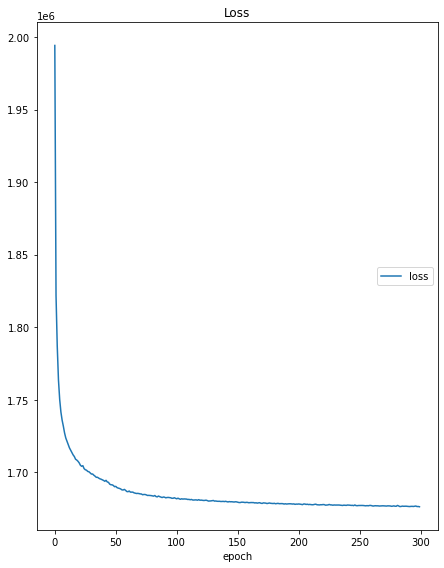

Loss
	loss             	 (min: 1676285.233, max: 1994127.874, cur: 1676285.233)
loss in epoch 300  : 1676285.2330271564


In [82]:

celeba_vae = None # your model (assign it below)

#solution
celeba_vae = VAE(bottleneck_size=512, channel_size=3).to(device)

train_loader = DataLoader(celeba_train_dataset, batch_size=32, shuffle=True)
optimizer = optim.Adam(celeba_vae.parameters(), lr=0.001)
celeba_vae.train()

liveloss = PlotLosses()
noOfEpochs = 300
for epoch in range(noOfEpochs):
    trainLoss = 0
    for batch in train_loader:
        image = batch.cuda()
        pred, mu, std = celeba_vae(image)
        loss = reconstruction_loss(pred, image) + kl_divergence_loss(mu, std)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainLoss /= len(train_loader)
    liveloss.update({'loss': trainLoss})
    liveloss.send()
    print("loss in epoch", format(epoch + 1, '03d'), " :", trainLoss)
#end_solution


Save model (needed for marking)

In [83]:
torch.save(celeba_vae, 'models/ex4_vae.pth')

Load pretrained model

In [84]:
celeba_vae = torch.load("models/ex4_vae.pth")

Generate and display 10 samples

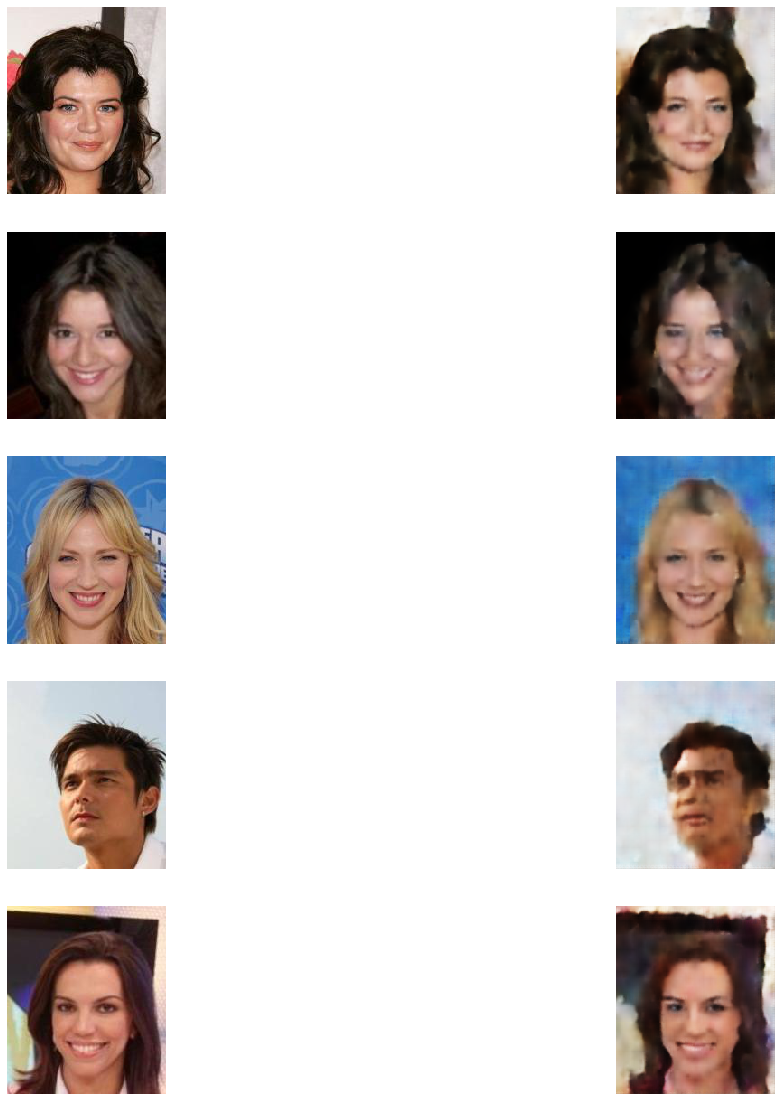

In [85]:
indices = np.random.choice(range(len(celeba_validation_dataset)), 5, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]


batch = torch.stack(celeba_random_images, dim=0)
gt_img = batch.to(device)

pred_img = celeba_vae(gt_img)[0].permute(0,2,3,1)

imgs_plot = [ el.cpu().squeeze().numpy() for el in gt_img.permute(0,2,3,1)]
pred_plot = [ el.cpu().detach().squeeze().numpy() for el in pred_img]
img = [imgs_plot, pred_plot, ]
plot_images(img, None, None)
plt.show()
plt.close()

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

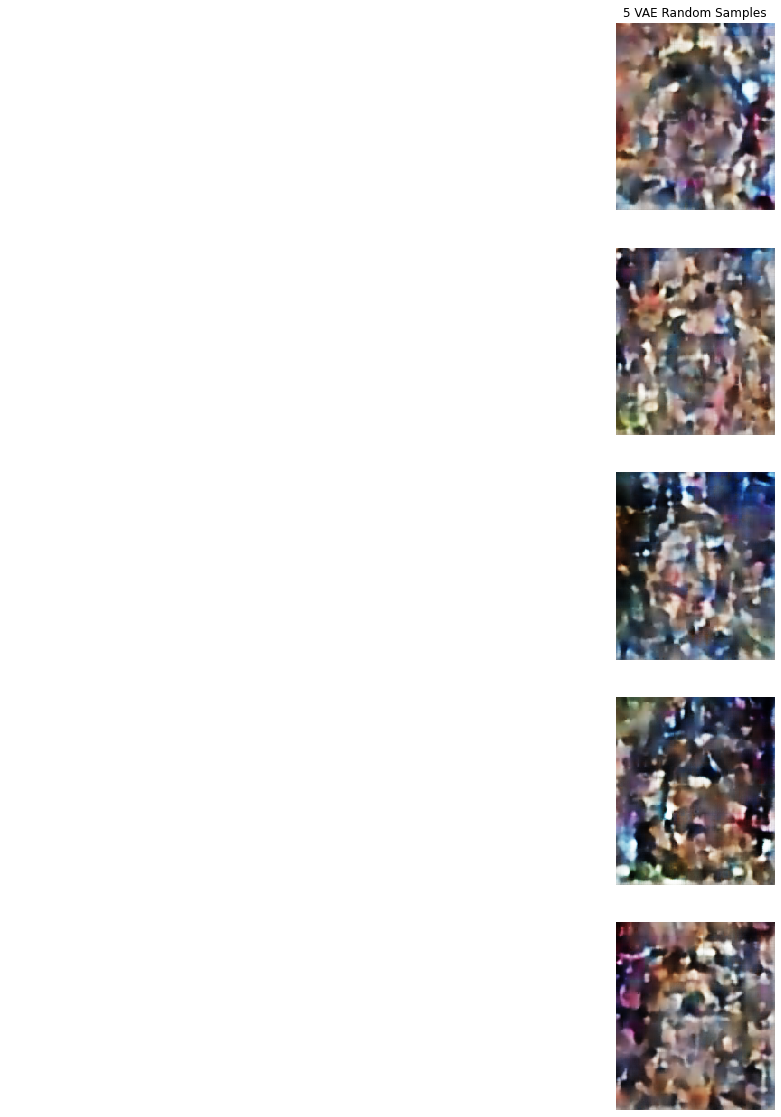

In [86]:
number_of_samples = 5


#solution
code = torch.randn((number_of_samples, celeba_vae.bottleneck_size))
code = code.to(device)

pred_img = celeba_vae.decoder(code).permute(0,2,3,1)
pred_plot = [ el.cpu().detach().squeeze().numpy() for el in pred_img]
blank_plot = [ np.ones_like(el) for el in pred_plot]
img = [blank_plot, pred_plot, ]
titles = [' ', '5 VAE Random Samples']
plot_images(img, titles, None)
plt.show()
plt.close() 
#end_solution


Save the AE model (needed for marking)

**Question 4.c**
<a name='question4c'></a>

Load the VAE and AE model

In [87]:
celeba_ae = torch.load('models/ex_3_ae.pth')
celeba_vae = torch.load('models/ex4_vae.pth')

Display samples from both AE and VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

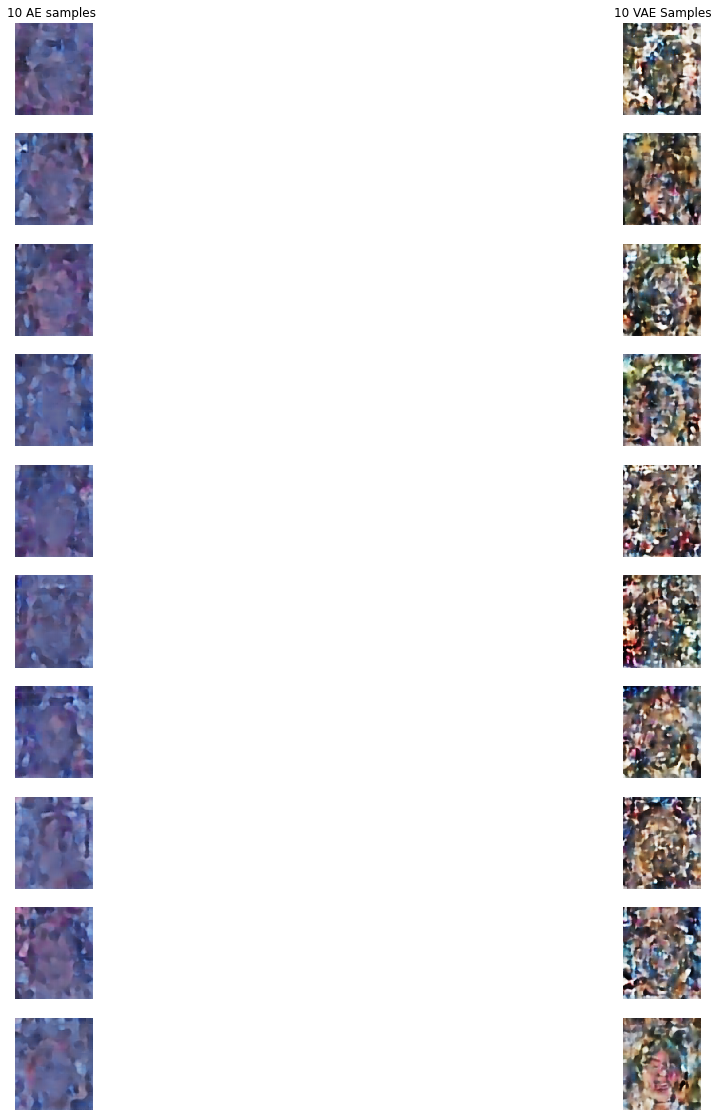

In [88]:
number_of_samples = 10

#solution
codeVAE = torch.randn((number_of_samples, celeba_vae.bottleneck_size))
codeVAE = codeVAE.to(device)

pred_img_vae = celeba_vae.decoder(codeVAE).permute(0,2,3,1)
pred_plot_vae = [ el.cpu().detach().squeeze().numpy() for el in pred_img_vae]

codeAE = torch.randn((number_of_samples, celeba_ae.bottleneck_size))
codeAE = codeAE.to(device)

pred_img_ae = celeba_ae.decoder(codeAE).permute(0,2,3,1)
pred_plot_ae = [ el.cpu().detach().squeeze().numpy() for el in pred_img_ae]

img = [pred_plot_ae, pred_plot_vae, ]
titles = ['10 AE samples ', '10 VAE Samples']
plot_images(img, titles, None)
plt.show()
plt.close() 
#end_solution



&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

For the above AE and VAE, we have keep the network architecture, optimizer, and all other hyper-parameters as close as possible. From the above random samples in the latent space of AE and VAE, we can see the main differnece between AE and VAE is that the latent space of VAE is regularized. For AE, the data may be mapped to a latent space which is non-regular.

**Question 4.d**
<a name='question4d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

The main differences between Adam and SGD is that for Adam we will use momentum during gradient descent. The learning rate is adaptive based on the first- and second-momentum of historical gradient in Adam.


>$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$

>$\nu_t = \beta_2 \nu_{t-1} + (1-\beta_2) g_t^2$

$m_t$ and $\nu_t$ are the first and second momentum estimate respectively, where $m_t$ is the decaying average of past gradients, and $\nu_t$ is the decaying average of past squared gradients. Since SGD has trouble navigating ravines (i.e. areas where the surface curves much more steeply in one dimension than in another), using the first- and second- momentum can help to tune the effective learning rate in an self-adaptive manner.

Note that initially $m_t$ and $\nu_t$ are started with 0 vectors, and the decay rates are small in the beginning where both betas are close to 1, result in both of them are biased towards 0. Therefore, we need to compute the bias-corrected terms $\hat{m}_t$ and $\hat{\nu}_t$:

>$\hat{m}_t = m_t / (1-\beta_1^t)$

>$\hat{\nu}_t = \nu_t / (1-\beta_2^t)$

Finally, we can update the paramter using the the bias-corrected terms.

>$\theta_t = \theta_{t-1} - \alpha\hat{m}_t/(\sqrt{\hat{\nu}_t} + \epsilon)$


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Adam optimizer for VAE on CelebA

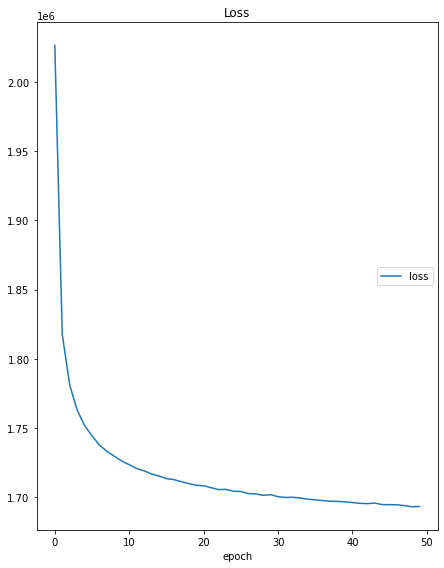

Loss
	loss             	 (min: 1693016.563, max: 2026479.176, cur: 1693232.028)
loss in epoch 050  : 1693232.028154952


In [105]:
celeba_vae = VAE(bottleneck_size=512, channel_size=3).to(device)
train_loader = DataLoader(celeba_train_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(celeba_vae.parameters(), lr=0.001)
celeba_vae.train()
adam_loss = []

liveloss = PlotLosses()
noOfEpochs = 50
for epoch in range(noOfEpochs):
    trainLoss = 0
    for batch in train_loader:
        image = batch.cuda()
        pred, mu, std = celeba_vae(image)
        loss = reconstruction_loss(pred, image) + kl_divergence_loss(mu, std)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trainLoss /= len(train_loader)
    adam_loss.append(trainLoss)
    liveloss.update({'loss': trainLoss})
    liveloss.send()
    print("loss in epoch", format(epoch + 1, '03d'), " :", trainLoss)

SGD optimizer for VAE on CelebA

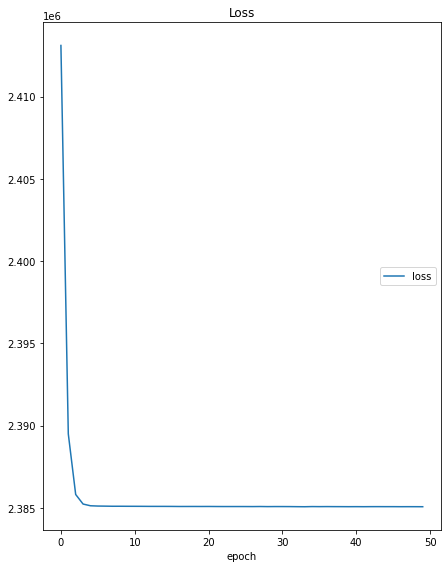

Loss
	loss             	 (min: 2385074.256, max: 2413104.838, cur: 2385075.282)
loss in epoch 050  : 2385075.2823482426


In [106]:
celeba_vae = VAE(bottleneck_size=512, channel_size=3).to(device)
train_loader = DataLoader(celeba_train_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.SGD(celeba_vae.parameters(), lr=0.00000001)
celeba_vae.train()
sgd_loss = []

liveloss = PlotLosses()
noOfEpochs = 50
for epoch in range(noOfEpochs):
    trainLoss = 0
    for batch in train_loader:
        image = batch.cuda()
        pred, mu, std = celeba_vae(image)
        loss = reconstruction_loss(pred, image) + kl_divergence_loss(mu, std)
        trainLoss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trainLoss /= len(train_loader)
    sgd_loss.append(trainLoss)
    liveloss.update({'loss': trainLoss})
    liveloss.send()
    print("loss in epoch", format(epoch + 1, '03d'), " :", trainLoss)

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

From the above and following loss curve, we can see that the loss using SDG is much larger than using Adam. Moreover, the main difference between training using SDG and Adam is the convergence speed. For Adam, we are using learning rate = 0.001, however for SDG we are using learning rate = 0.00000001 which is much smaller than the learning rate using Adam. This indicates that the convergence speed will be much slower when using SDG since each step is smaller.

We can see that Adam has a much better performance SGD since Adam uses the momentum to udpate the parameters and can address the problem of SDG as mentioned above. 

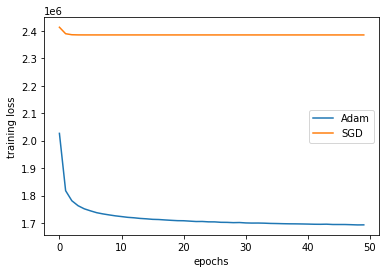

In [107]:
plt.plot(adam_loss, label='Adam')
plt.plot(sgd_loss, label='SGD')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend()
plt.show()